# Distributed Enhanced Suffix Arrays
## Runtime analysis and figures

Code to parse log files from experiments and generate all the figures used in the paper.
This code outputs the shown figures as pdf files straight for the latex document.

### First: some useful functions for parsing log files

In [1]:
import os
import re
import numpy as np

In [2]:
# parse TIMER stuff into some datastructure
def parse_runlog(file, secs={}):
    with open(file, "r") as myfile:
        for line in myfile.read().splitlines():
            row = line.split('\t')
            if row[0] == "TIMER":
                sec = row[5]
                hierarchy = float(row[4])
                if not sec in secs:
                    secs[sec] = {"hier":hierarchy,
                                 "mintime":[float(row[1])/1000.], # time is logged in [ms], convert to [s]
                                 "avgtime":[float(row[2])/1000.],
                                 "maxtime":[float(row[3])/1000.]}
                else:
                    secs[sec]["mintime"].append(float(row[1])/1000.)
                    secs[sec]["avgtime"].append(float(row[2])/1000.)
                    secs[sec]["maxtime"].append(float(row[3])/1000.)
    return secs

In [3]:
# PARSE all logs in given folder
def parse_all(folder, by=-1, parser=parse_runlog):
    logs = {}
    for f in os.listdir(folder):
        if f[0:6] == "runlog":
            cores = int(f.split(".")[0].split("_")[by])
            if not cores in logs:
                logs[cores] = {}
            logs[cores] = parser(os.path.join(folder,f), logs[cores])
    return logs

In [4]:
# extract and aggregate time per core count
def get_runtime(logs, field, agg=np.mean, timer="maxtime"):
    cores = list(logs.keys())
    cores.sort()
    time = []
    for p in cores:
        if not field in logs[p]:
            time.append(float("NaN"))
        else:
            runtimes = np.array(logs[p][field][timer])
            time.append(agg(runtimes))
    return np.array(cores), np.array(time)

In [5]:
# parser for DPT logs
def parse_dpt(file, secs = {}):
    with open(file, "r") as f:
        for line in f.read().splitlines():
            if "TIME" in line:
                line = line.split(" ")
                if not line[0] in secs:
                    secs[line[0]] = {"maxtime": [float(line[2])]}
                else:
                    secs[line[0]]["maxtime"].append(float(line[2]))
    return secs

In [6]:
# parser for PSAC logs (only total time)
def parse_psac(file, secs = {}):
    with open(file, "r") as f:
        for line in f.read().splitlines():
            if "PSAC time" in line:
                line = line.split(" ")
                if not line[0] in secs:
                    secs[line[0]] = {"maxtime": [float(line[2])/1000.]}
                else:
                    secs[line[0]]["maxtime"].append(float(line[2])/1000.)
    return secs

In [7]:
# QUERY phases in log:
#   Phase I: local queries
#   Phase I: all2all patterns
#   Phase II: local_locate_possible
#   all2all patterns for cmp
#   Phase III: local strcmp
#   return P3 results
#   return P2 results
# bulk_locate

# splitting into comp and comm:
def desa_comp_comm(logs, agg):
    phases_comp = ["Phase I: local queries", 
                   "Phase II: local_locate_possible",
                   "Phase III: local strcmp"]
    phases_comm = ["Phase I: all2all patterns",
                   "all2all patterns for cmp",
                   "return P3 results",
                   "return P2 results"]

    time_comp = sum(get_runtime(desa_logs, ph, agg)[1] for ph in phases_comp)
    time_comm = sum(get_runtime(desa_logs, ph, agg)[1] for ph in phases_comm)
    return time_comp, time_comm


# DESA vs DPT

Comparing DESA and DPT using chromosome 1 (chr1).

## DESA vs DPT Construction

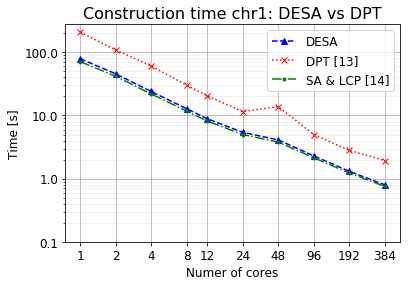

In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Construction time for chr1 DESA vs DPT
desa_logs = parse_all("stampede/psac-desa-new/runlog/constr_chr1", by=-2)
cores, time = get_runtime(desa_logs, "construct idx")
_, time_naivelc = get_runtime(desa_logs, "desa_construct: Lc naive construct")
_, time_salcp = get_runtime(desa_logs, "desa_construct: SA/LCP construct")
time = time - time_naivelc# - time_salcp

dpt_logs = parse_all("stampede/dpt/runlogs/chr1_10M", by=-1, parser=parse_dpt)
cores_dpt, time_dpt = get_runtime(dpt_logs, "CONSTRUCTION", np.mean)
time_dpt = time_dpt + time_salcp


f = plt.figure()

plt.plot(cores, time, 'b^--', label="DESA")
plt.plot(cores_dpt, time_dpt, 'rx:', label="DPT [13]")
plt.plot(cores, time_salcp, 'g.-.', label="SA & LCP [14]")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.gca().set_xticks(cores, minor=False)
plt.gca().set_xticks([], minor=True)
plt.gca().set_yticks([0.1,1,10,100], minor=False)
plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.gca().get_xaxis().set_tick_params(which='minor', size=0)
plt.gca().get_xaxis().set_tick_params(which='minor', width=0)
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=1)

plt.xlabel("Numer of cores", fontsize=12)
plt.ylabel("Time [s]", fontsize=12)
plt.title("Construction time chr1: DESA vs DPT", fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.show()

f.savefig("constr_chr1_incl_SALCP.pdf", bbox_inches='tight')
# TODO: how to represent the constr scaling !?

In [9]:
time_dpt / time # from SA&LCP: 14.1x - 25.7x faster

array([2.64405774, 2.39052316, 2.53658008, 2.35768828, 2.30111507,
       2.13110234, 3.36751116, 2.17791638, 2.14988992, 2.41671996])

In [10]:
time_dpt / time # incl SA&LCP: 2.0x - 2.6x faster

array([2.64405774, 2.39052316, 2.53658008, 2.35768828, 2.30111507,
       2.13110234, 3.36751116, 2.17791638, 2.14988992, 2.41671996])

## DESA vs DTP query

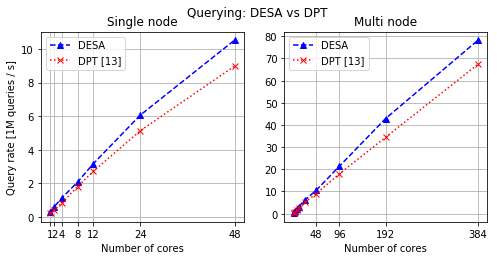

In [11]:
# load DESA logs
desa_logs = parse_all("stampede/psac-desa-new/runlog/chr1_10M")
cores, time_desa = get_runtime(desa_logs, "bulk_locate", np.mean)
# load DPT logs
dpt_logs = parse_all("stampede/dpt/runlogs/chr1_10M", by=-1, parser=parse_dpt)
cores_dpt, time_dpt = get_runtime(dpt_logs, "QUERY", np.mean)
assert((cores_dpt == cores).all())

base = 10 # Million Queries per second MQs

fig = plt.figure(figsize=(8,3.5)) # (10,4) -> 3.5, 0.4*3.5
plt.suptitle("Querying: DESA vs DPT")

# zoomed in plot
plt.subplot(1, 2, 1)

plt.plot(cores[:7], base/time_desa[:7], 'b^--', label="DESA")
plt.plot(cores[:7], base/time_dpt[:7], 'rx:', label="DPT [13]")
plt.xlabel("Number of cores")
plt.xticks(cores[:7])
plt.ylabel("Query rate [1M queries / s]")
plt.title("Single node")
plt.legend(loc="upper left")
plt.grid()

# complete data
plt.subplot(1, 2, 2)

plt.plot(cores, base/time_desa, 'b^--', label="DESA")
plt.plot(cores, base/time_dpt, 'rx:', label="DPT [13]")
plt.xlabel("Number of cores")
plt.xticks(cores[6:])
#plt.ylabel("Query rate [1M queries / s]")
plt.title("Multi node")
plt.legend(loc="upper left")
plt.grid()

plt.show()
fig.savefig("query_chr1.pdf", bbox_inches='tight')

### How much faster is DESA ?

In [12]:
rel=(1-(time_desa / time_dpt))*100 # 13% - 29% faster
print("relative differences: ", rel)
print("min =", min(rel), ", max =", max(rel))

relative differences:  [21.69407333 29.02216505 26.04000526 13.08181351 14.36298362 15.33023262
 14.67525012 16.02702539 19.67464788 13.8684124 ]
min = 13.081813507720918 , max = 29.022165045048087


## Speedup of DESA?

In [13]:
# speedup?
print("Local speedup", time_desa[0]/time_desa[cores == 48])
print("Nodes speedup", time_desa[cores == 48]/time_desa[cores == 384])
print("TOtal speedup", time_desa[0]/time_desa[cores == 384])

Local speedup [36.4257119]
Nodes speedup [7.43821412]
TOtal speedup [270.94224448]


# Scaling
## DESA querying weak scaling


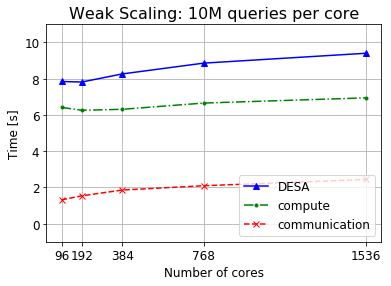

In [14]:
# weak scaling experiment results
desa_logs = parse_all("stampede/psac-desa-new/runlog/weak_1M_100")
cores, time_desa = get_runtime(desa_logs, "bulk_locate", np.mean)
time_comp, time_comm = desa_comp_comm(desa_logs, np.mean)

plt.plot(cores, time_desa, "b^-", label="DESA")
plt.plot(cores, time_comp, "g.-.", label="compute")
plt.plot(cores, time_comm, "rx--", label="communication")

plt.xticks(cores, fontsize=12)
plt.yticks(fontsize=12)
pad=1
plt.ylim(bottom=0-pad,ymax=10+pad)
plt.title("Weak Scaling: 10M queries per core", fontsize=16)
plt.xlabel("Number of cores", fontsize=12)
plt.ylabel("Time [s]", fontsize=12)
plt.grid()
plt.legend(loc="lower right", fontsize=12)
plt.show()
fig.savefig("desa_scaling.pdf", bbox_inches='tight')

Percent increase from 2 nodes to 32 nodes:

In [15]:
print("Total percent increase:", (time_desa[-1] - time_desa[0])/time_desa[0]*100)
print("Comp percent increase:", (time_comp[-1] - time_comp[0])/time_comp[0]*100)
print("Comm percent increase:", (time_comm[-1] - time_comm[0])/time_comm[0]*100)


Total percent increase: 19.854468529775353
Comp percent increase: 8.196179749368103
Comm percent increase: 85.7369159846049


## DESA Construction Breakdown

In [16]:
# extract all the data from the logs
psac_logs = parse_all("stampede/psac-desa-new/runlog/constr_psac_human_new", by=-2, parser=parse_psac)
cores_psac, time_psac = get_runtime(psac_logs, "PSAC", np.mean)

desa_logs = parse_all("stampede/psac-desa-new/runlog/constr_human_new", by=-2)
cores, time_desa = get_runtime(desa_logs, "construct idx", np.mean)
_, time_salcplc = get_runtime(desa_logs, "desa_construct: SA/LCP construct", np.mean)
_, time_tldt = get_runtime(desa_logs, "desa_construct: TLI construct", np.mean)
_, time_partition = get_runtime(desa_logs, "desa_construct: 1-D partition", np.mean)
_, time_redistr = get_runtime(desa_logs, "desa_construct: repartition", np.mean)
_, time_rmq = get_runtime(desa_logs, "desa_construct: RMQ construct", np.mean)
_, time_lcnaive = get_runtime(desa_logs, "desa_construct: Lc naive construct", np.mean)

assert((cores == cores_psac).all())

print(time_psac)
print(time_salcplc)

time_desa = time_desa - time_lcnaive
time_desa2 = time_salcplc + time_tldt + time_partition + time_redistr + time_rmq
print("desa - lcnaive:", time_desa)
print("salcplc + ...:", time_desa2)

perc_desa = (time_desa - time_psac)/time_psac

#plt.plot(cores, time_psac, 'rx:')
#plt.plot(cores, time_salcplc, 'b^:')
#plt.plot(cores, time_desa, 'g.--')

[27.674  15.75    8.8511  5.625   4.5612]
[27.852  15.83    8.9137  5.245   4.0878]
desa - lcnaive: [29.8895  16.86     9.49575  5.54274  4.2782 ]
salcplc + ...: [29.86399038 16.84392722  9.4850424   5.5363592   4.2700212 ]


Compute percentage contributions of each step

max Lc: 0.007072567251528033
max Lc naive 11.32149322373893


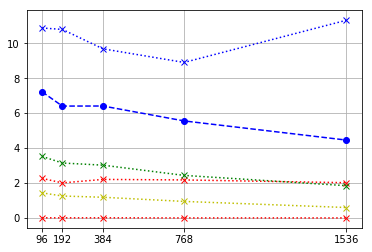

In [17]:
perc_desa = (time_desa2 - time_salcplc)/time_salcplc*100
perc_tldt = time_tldt/time_salcplc*100
perc_redist = (time_partition + time_redistr) / time_salcplc * 100
perc_rmq = time_rmq/time_salcplc*100
perc_lc = (time_salcplc - time_psac)/time_psac
perc_lcnaive = (time_lcnaive)/time_salcplc*100

plt.plot(cores, perc_desa, 'bo--')
plt.plot(cores, perc_tldt, 'rx:')
plt.plot(cores, perc_redist, 'gx:')
plt.plot(cores, perc_rmq, 'yx:')
plt.plot(cores, perc_lc.clip(0), 'rx:')
plt.plot(cores, perc_lcnaive, 'bx:')


print("max Lc:", max(perc_lc))
print("max Lc naive", max(perc_lcnaive))

plt.xticks(cores)
#plt.ylim((0,11))
#plt.yticks(range(0,11))
plt.grid()

### Contribution breakdown

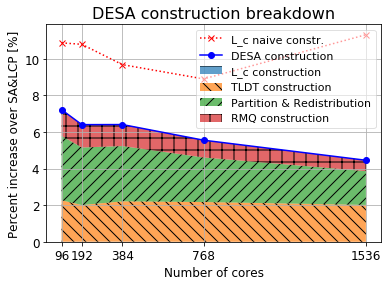

In [18]:
#plt.rc('figure', titlesize=20)
fig = plt.figure()
# stack plot
stack = [perc_lc.clip(0), perc_tldt, perc_redist, perc_rmq]
stlabel = ["L_c construction", "TLDT construction", "Partition & Redistribution", "RMQ construction"]
st = plt.stackplot(cores,stack, labels=stlabel, alpha=0.7)
# add lines for naive LC construction and total DESA time
plt.plot(cores, perc_lcnaive, 'rx:', label="L_c naive constr.")
plt.plot(cores, perc_desa, 'bo-', label="DESA construction")
plt.xticks(cores, fontsize=12)
plt.yticks(fontsize=12)
plt.grid()

hatches=["-","\\\\", "//","+"]
for s, h in zip(st, hatches):
    s.set_hatch(h)
    
plt.legend(loc="upper right", fontsize=11, framealpha=0.6)
plt.xlabel("Number of cores", fontsize=12)
plt.ylabel("Percent increase over SA&LCP [%]", fontsize=12)
plt.title("DESA construction breakdown", fontsize=16)

fig.savefig("desa_constr_breakdown.pdf", bbox_inches='tight')